In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 184)
(734160, 1)
validation
(101248, 184)
(101248, 1)
test
(100432, 184)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 878593 (3.35 MB)


Trainable params: 878593 (3.35 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:22 - loss: 0.0733 - STD: 1.0444e-04 - MAE: 0.2605

 7/74 [=>............................] - ETA: 0s - loss: 0.0332 - STD: 4.7208e-05 - MAE: 0.1425  

13/74 [====>.........................] - ETA: 0s - loss: 0.0256 - STD: 5.1226e-05 - MAE: 0.1171

19/74 [======>.......................] - ETA: 0s - loss: 0.0225 - STD: 6.1876e-05 - MAE: 0.1132

25/74 [=========>....................] - ETA: 0s - loss: 0.0203 - STD: 6.8206e-05 - MAE: 0.1009

31/74 [===========>..................] - ETA: 0s - loss: 0.0188 - STD: 7.6378e-05 - MAE: 0.0942

37/74 [==============>...............] - ETA: 0s - loss: 0.0178 - STD: 8.6350e-05 - MAE: 0.0925

43/74 [================>.............] - ETA: 0s - loss: 0.0170 - STD: 9.5049e-05 - MAE: 0.0887

49/74 [==================>...........] - ETA: 0s - loss: 0.0164 - STD: 1.0446e-04 - MAE: 0.0859

55/74 [=====================>........] - ETA: 0s - loss: 0.0159 - STD: 1.1540e-04 - MAE: 0.0846

57/74 [======================>.......] - ETA: 0s - loss: 0.0158 - STD: 1.1898e-04 - MAE: 0.0841

63/74 [========================>.....] - ETA: 0s - loss: 0.0155 - STD: 1.3003e-04 - MAE: 0.0823

69/74 [==========================>...] - ETA: 0s - loss: 0.0152 - STD: 1.4260e-04 - MAE: 0.0812

74/74 [==============================] - 3s 25ms/step - loss: 0.0150 - STD: 1.5400e-04 - MAE: 0.0805 - val_loss: 0.0145 - val_STD: 2.8214e-04 - val_MAE: 0.0728


Epoch 2/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0117 - STD: 3.2910e-04 - MAE: 0.0678

 7/74 [=>............................] - ETA: 0s - loss: 0.0119 - STD: 3.5324e-04 - MAE: 0.0680

13/74 [====>.........................] - ETA: 0s - loss: 0.0120 - STD: 3.8120e-04 - MAE: 0.0689

19/74 [======>.......................] - ETA: 0s - loss: 0.0119 - STD: 4.0929e-04 - MAE: 0.0687

25/74 [=========>....................] - ETA: 0s - loss: 0.0119 - STD: 4.4229e-04 - MAE: 0.0687

31/74 [===========>..................] - ETA: 0s - loss: 0.0119 - STD: 4.7986e-04 - MAE: 0.0688

37/74 [==============>...............] - ETA: 0s - loss: 0.0119 - STD: 5.2282e-04 - MAE: 0.0688

43/74 [================>.............] - ETA: 0s - loss: 0.0119 - STD: 5.7256e-04 - MAE: 0.0689

49/74 [==================>...........] - ETA: 0s - loss: 0.0119 - STD: 6.2968e-04 - MAE: 0.0689

55/74 [=====================>........] - ETA: 0s - loss: 0.0119 - STD: 6.9843e-04 - MAE: 0.0689

61/74 [=======================>......] - ETA: 0s - loss: 0.0119 - STD: 7.8073e-04 - MAE: 0.0689

67/74 [==========================>...] - ETA: 0s - loss: 0.0119 - STD: 8.8082e-04 - MAE: 0.0688

73/74 [============================>.] - ETA: 0s - loss: 0.0119 - STD: 0.0010 - MAE: 0.0688    

74/74 [==============================] - 1s 11ms/step - loss: 0.0119 - STD: 0.0010 - MAE: 0.0688 - val_loss: 0.0141 - val_STD: 0.0025 - val_MAE: 0.0726


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0108 - STD: 0.0029 - MAE: 0.0660

 7/74 [=>............................] - ETA: 0s - loss: 0.0116 - STD: 0.0034 - MAE: 0.0676

13/74 [====>.........................] - ETA: 0s - loss: 0.0115 - STD: 0.0040 - MAE: 0.0674

19/74 [======>.......................] - ETA: 0s - loss: 0.0114 - STD: 0.0047 - MAE: 0.0671

25/74 [=========>....................] - ETA: 0s - loss: 0.0113 - STD: 0.0059 - MAE: 0.0667

31/74 [===========>..................] - ETA: 0s - loss: 0.0111 - STD: 0.0075 - MAE: 0.0661

37/74 [==============>...............] - ETA: 0s - loss: 0.0108 - STD: 0.0098 - MAE: 0.0653

43/74 [================>.............] - ETA: 0s - loss: 0.0105 - STD: 0.0131 - MAE: 0.0642

49/74 [==================>...........] - ETA: 0s - loss: 0.0101 - STD: 0.0176 - MAE: 0.0630

55/74 [=====================>........] - ETA: 0s - loss: 0.0097 - STD: 0.0226 - MAE: 0.0615

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 0.0277 - MAE: 0.0600

67/74 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0325 - MAE: 0.0583

73/74 [============================>.] - ETA: 0s - loss: 0.0083 - STD: 0.0370 - MAE: 0.0567

74/74 [==============================] - 1s 11ms/step - loss: 0.0082 - STD: 0.0378 - MAE: 0.0564 - val_loss: 0.0032 - val_STD: 0.0693 - val_MAE: 0.0347


Epoch 4/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0947 - MAE: 0.0374

 7/74 [=>............................] - ETA: 0s - loss: 0.0032 - STD: 0.0913 - MAE: 0.0364

13/74 [====>.........................] - ETA: 0s - loss: 0.0030 - STD: 0.0924 - MAE: 0.0358

19/74 [======>.......................] - ETA: 0s - loss: 0.0030 - STD: 0.0931 - MAE: 0.0357

25/74 [=========>....................] - ETA: 0s - loss: 0.0030 - STD: 0.0940 - MAE: 0.0354

31/74 [===========>..................] - ETA: 0s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0352

37/74 [==============>...............] - ETA: 0s - loss: 0.0029 - STD: 0.0942 - MAE: 0.0350

43/74 [================>.............] - ETA: 0s - loss: 0.0029 - STD: 0.0943 - MAE: 0.0348

49/74 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0945 - MAE: 0.0347

55/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0948 - MAE: 0.0346

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0950 - MAE: 0.0345

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0344

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0952 - MAE: 0.0344

74/74 [==============================] - 1s 11ms/step - loss: 0.0028 - STD: 0.0952 - MAE: 0.0343 - val_loss: 0.0028 - val_STD: 0.0762 - val_MAE: 0.0331


Epoch 5/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0335

 7/74 [=>............................] - ETA: 0s - loss: 0.0027 - STD: 0.0969 - MAE: 0.0336

13/74 [====>.........................] - ETA: 0s - loss: 0.0026 - STD: 0.0960 - MAE: 0.0334

19/74 [======>.......................] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0334

25/74 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.0962 - MAE: 0.0334

31/74 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0333

37/74 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0333

43/74 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0332

49/74 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0959 - MAE: 0.0332

55/74 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0961 - MAE: 0.0332

61/74 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0332

67/74 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0962 - MAE: 0.0332

73/74 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332

74/74 [==============================] - 1s 11ms/step - loss: 0.0026 - STD: 0.0963 - MAE: 0.0332 - val_loss: 0.0027 - val_STD: 0.0764 - val_MAE: 0.0324


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0946 - MAE: 0.0326

 7/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0961 - MAE: 0.0327

13/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

19/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0963 - MAE: 0.0327

25/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0327

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0326

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0326

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0965 - MAE: 0.0326

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0966 - MAE: 0.0327

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327

74/74 [==============================] - 1s 10ms/step - loss: 0.0025 - STD: 0.0967 - MAE: 0.0327 - val_loss: 0.0027 - val_STD: 0.0769 - val_MAE: 0.0326


Epoch 7/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0328

 7/74 [=>............................] - ETA: 0s - loss: 0.0025 - STD: 0.0964 - MAE: 0.0325

13/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0325

19/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0326

25/74 [=========>....................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0327

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0327

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0327

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0326

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0325

67/74 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0325

73/74 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0324

74/74 [==============================] - 1s 11ms/step - loss: 0.0025 - STD: 0.0970 - MAE: 0.0324 - val_loss: 0.0026 - val_STD: 0.0775 - val_MAE: 0.0318


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0970 - MAE: 0.0323

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0320

13/74 [====>.........................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0322

19/74 [======>.......................] - ETA: 0s - loss: 0.0025 - STD: 0.0969 - MAE: 0.0322

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321

31/74 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.0974 - MAE: 0.0322

37/74 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0322

43/74 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0322

49/74 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0971 - MAE: 0.0322

55/74 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0322

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0972 - MAE: 0.0321

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0321

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0971 - MAE: 0.0321

74/74 [==============================] - 1s 10ms/step - loss: 0.0024 - STD: 0.0972 - MAE: 0.0321 - val_loss: 0.0027 - val_STD: 0.0799 - val_MAE: 0.0335


Epoch 9/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0025 - STD: 0.0994 - MAE: 0.0324

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0319

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0319

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0318

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0320

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0320

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0319

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0319

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0318

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0973 - MAE: 0.0318

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0318

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0974 - MAE: 0.0318

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0975 - MAE: 0.0318 - val_loss: 0.0026 - val_STD: 0.0795 - val_MAE: 0.0319


Epoch 10/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0314

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0314

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0314

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0314

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0314

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0976 - MAE: 0.0314

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0975 - MAE: 0.0314

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0314

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0315

74/74 [==============================] - 1s 10ms/step - loss: 0.0024 - STD: 0.0977 - MAE: 0.0315 - val_loss: 0.0027 - val_STD: 0.0794 - val_MAE: 0.0333


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0024 - STD: 0.0984 - MAE: 0.0316

13/74 [====>.........................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0314

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0314

31/74 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0313

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0313

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0977 - MAE: 0.0314

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0315

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0316

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0315

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0314

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0978 - MAE: 0.0314 - val_loss: 0.0027 - val_STD: 0.0805 - val_MAE: 0.0326


Epoch 12/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0310

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0311

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0312

19/74 [======>.......................] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0312

25/74 [=========>....................] - ETA: 0s - loss: 0.0024 - STD: 0.0982 - MAE: 0.0312

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0311

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0311

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0311

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311 - val_loss: 0.0028 - val_STD: 0.0820 - val_MAE: 0.0336


Epoch 13/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1014 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0314

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0313

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0978 - MAE: 0.0312

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0312

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0314

37/74 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.0983 - MAE: 0.0315

43/74 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0981 - MAE: 0.0317

49/74 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0316

55/74 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0980 - MAE: 0.0316

61/74 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0978 - MAE: 0.0316

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0315

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0979 - MAE: 0.0315

74/74 [==============================] - 1s 11ms/step - loss: 0.0024 - STD: 0.0979 - MAE: 0.0315 - val_loss: 0.0026 - val_STD: 0.0800 - val_MAE: 0.0312


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0999 - MAE: 0.0310

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0306

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0307

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0308

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0309

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0310

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0980 - MAE: 0.0310

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0310

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0310

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0311

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0311

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0311

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0312

74/74 [==============================] - 1s 10ms/step - loss: 0.0023 - STD: 0.0980 - MAE: 0.0311 - val_loss: 0.0028 - val_STD: 0.0823 - val_MAE: 0.0337


Epoch 15/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.1012 - MAE: 0.0316

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0996 - MAE: 0.0308

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0308

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0308

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0307

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0307

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0307

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0307

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

61/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

67/74 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

73/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307 - val_loss: 0.0026 - val_STD: 0.0795 - val_MAE: 0.0308


Epoch 16/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0303

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0307

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0307

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0308

24/74 [========>.....................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0308

30/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0981 - MAE: 0.0308

36/74 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0308

42/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0308

48/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0308

54/74 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

60/74 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0307

66/74 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0307

72/74 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

74/74 [==============================] - 1s 11ms/step - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306 - val_loss: 0.0027 - val_STD: 0.0815 - val_MAE: 0.0330


Epoch 17/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0305

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0304

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0982 - MAE: 0.0306

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0984 - MAE: 0.0306

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0305

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305 - val_loss: 0.0027 - val_STD: 0.0826 - val_MAE: 0.0324


Epoch 18/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0024 - STD: 0.1004 - MAE: 0.0308

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0308

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0992 - MAE: 0.0308

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0307

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0306

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0306

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0306

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0988 - MAE: 0.0307

49/74 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0989 - MAE: 0.0306

55/74 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0986 - MAE: 0.0305

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0305

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0305

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0305 - val_loss: 0.0026 - val_STD: 0.0824 - val_MAE: 0.0323


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0307

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0305

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0305

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0305

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0303 - val_loss: 0.0027 - val_STD: 0.0817 - val_MAE: 0.0340


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0995 - MAE: 0.0307

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0304

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0304

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0303

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0303

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0303

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304 - val_loss: 0.0027 - val_STD: 0.0813 - val_MAE: 0.0340


Epoch 21/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.0968 - MAE: 0.0308

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0303

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0303

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

31/74 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0306

37/74 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.0983 - MAE: 0.0306

43/74 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0306

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0305

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0304

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304 - val_loss: 0.0027 - val_STD: 0.0809 - val_MAE: 0.0337


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0994 - MAE: 0.0313

 7/74 [=>............................] - ETA: 0s - loss: 0.0023 - STD: 0.0991 - MAE: 0.0307

13/74 [====>.........................] - ETA: 0s - loss: 0.0023 - STD: 0.0987 - MAE: 0.0306

19/74 [======>.......................] - ETA: 0s - loss: 0.0023 - STD: 0.0990 - MAE: 0.0306

25/74 [=========>....................] - ETA: 0s - loss: 0.0023 - STD: 0.0985 - MAE: 0.0305

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0304

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0303

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0302

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0301

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302 - val_loss: 0.0025 - val_STD: 0.0811 - val_MAE: 0.0307


Epoch 23/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0300

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0304

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0303

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0302

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0302

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301 - val_loss: 0.0026 - val_STD: 0.0825 - val_MAE: 0.0323


Epoch 24/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0974 - MAE: 0.0297

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300 - val_loss: 0.0026 - val_STD: 0.0827 - val_MAE: 0.0321


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0981 - MAE: 0.0301

 6/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0974 - MAE: 0.0298

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0984 - MAE: 0.0298

18/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0299

24/74 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

29/74 [==========>...................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

35/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

41/74 [===============>..............] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

47/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

53/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

59/74 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299 - val_loss: 0.0027 - val_STD: 0.0836 - val_MAE: 0.0333


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0304

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0302

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0300

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0299

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300 - val_loss: 0.0025 - val_STD: 0.0811 - val_MAE: 0.0305


Epoch 27/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0971 - MAE: 0.0293

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0297

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0297

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0297

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0298

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299 - val_loss: 0.0025 - val_STD: 0.0787 - val_MAE: 0.0303


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0293

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0304

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0304

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0302

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300 - val_loss: 0.0025 - val_STD: 0.0817 - val_MAE: 0.0301


Epoch 29/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0967 - MAE: 0.0286

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0982 - MAE: 0.0296

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0295

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0297

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0297

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0297

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0991 - MAE: 0.0297 - val_loss: 0.0025 - val_STD: 0.0800 - val_MAE: 0.0309


Epoch 30/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0300

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.1000 - MAE: 0.0299

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0296

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0299

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0299

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0300

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0301

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

74/74 [==============================] - 1s 11ms/step - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299 - val_loss: 0.0026 - val_STD: 0.0823 - val_MAE: 0.0315


Epoch 31/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0982 - MAE: 0.0301

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0299

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0296

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0295

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297 - val_loss: 0.0025 - val_STD: 0.0808 - val_MAE: 0.0304


Epoch 32/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0295

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0298

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0298

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0299

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0302

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0303

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0303

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0302

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0301

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0300

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0991 - MAE: 0.0299 - val_loss: 0.0025 - val_STD: 0.0826 - val_MAE: 0.0303


Epoch 33/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0963 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

36/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0295

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295 - val_loss: 0.0025 - val_STD: 0.0823 - val_MAE: 0.0304


Epoch 34/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0295

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0296

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0296

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296 - val_loss: 0.0027 - val_STD: 0.0843 - val_MAE: 0.0329


Epoch 35/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1040 - MAE: 0.0302

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0297

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0300

18/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0986 - MAE: 0.0301

24/74 [========>.....................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0301

30/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0301

36/74 [=============>................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0300

42/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300

48/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0990 - MAE: 0.0299

54/74 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0300

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0300

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0300

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0300

74/74 [==============================] - 1s 10ms/step - loss: 0.0022 - STD: 0.0990 - MAE: 0.0300 - val_loss: 0.0027 - val_STD: 0.0838 - val_MAE: 0.0335


Epoch 36/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1009 - MAE: 0.0300

 6/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0296

12/74 [===>..........................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0297

18/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0298

24/74 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0297

30/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0297

36/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0296

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0296

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295 - val_loss: 0.0025 - val_STD: 0.0804 - val_MAE: 0.0298


Epoch 37/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0969 - MAE: 0.0294

 6/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0296

12/74 [===>..........................] - ETA: 0s - loss: 0.0022 - STD: 0.0998 - MAE: 0.0297

18/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0297

24/74 [========>.....................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0296

30/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0296

36/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

42/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0295

48/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

54/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

60/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

66/74 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

72/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294 - val_loss: 0.0025 - val_STD: 0.0817 - val_MAE: 0.0309


Epoch 38/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0969 - MAE: 0.0295

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0292

14/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0293

20/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0294

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0294

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0294

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294 - val_loss: 0.0025 - val_STD: 0.0810 - val_MAE: 0.0297


Epoch 39/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0952 - MAE: 0.0293

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0298

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0298

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0299

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0300

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0300

43/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0299

49/74 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

55/74 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0298

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297 - val_loss: 0.0025 - val_STD: 0.0806 - val_MAE: 0.0320


Epoch 40/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0936 - MAE: 0.0293

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295 - val_loss: 0.0026 - val_STD: 0.0832 - val_MAE: 0.0319


Epoch 41/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1006 - MAE: 0.0292

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0295

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296 - val_loss: 0.0025 - val_STD: 0.0808 - val_MAE: 0.0303


Epoch 42/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.0985 - MAE: 0.0298

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0997 - MAE: 0.0301

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0996 - MAE: 0.0300

19/74 [======>.......................] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0300

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0299

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0992 - MAE: 0.0298

37/74 [==============>...............] - ETA: 0s - loss: 0.0022 - STD: 0.0991 - MAE: 0.0298

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294 - val_loss: 0.0025 - val_STD: 0.0809 - val_MAE: 0.0311


Epoch 43/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0955 - MAE: 0.0292

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0293

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0295

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0296

25/74 [=========>....................] - ETA: 0s - loss: 0.0022 - STD: 0.0989 - MAE: 0.0298

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0295

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295 - val_loss: 0.0025 - val_STD: 0.0821 - val_MAE: 0.0301


Epoch 44/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0292

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0291

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0291

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0292

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0293

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294 - val_loss: 0.0025 - val_STD: 0.0812 - val_MAE: 0.0298


Epoch 45/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0296

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0290

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0295

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0994 - MAE: 0.0295 - val_loss: 0.0026 - val_STD: 0.0828 - val_MAE: 0.0324


Epoch 46/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.1029 - MAE: 0.0301

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0297

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0297

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0297

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0298

31/74 [===========>..................] - ETA: 0s - loss: 0.0022 - STD: 0.0993 - MAE: 0.0298

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0297

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0296

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295 - val_loss: 0.0025 - val_STD: 0.0826 - val_MAE: 0.0304


Epoch 47/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0980 - MAE: 0.0287

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0294

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0294

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0293

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0292

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292 - val_loss: 0.0025 - val_STD: 0.0823 - val_MAE: 0.0303


Epoch 48/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0980 - MAE: 0.0292

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0293

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291 - val_loss: 0.0025 - val_STD: 0.0840 - val_MAE: 0.0307


Epoch 49/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0288

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1003 - MAE: 0.0289

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1002 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0290

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0291

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0293

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0296

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0296

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0993 - MAE: 0.0297 - val_loss: 0.0030 - val_STD: 0.0856 - val_MAE: 0.0374


Epoch 50/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1037 - MAE: 0.0332

 7/74 [=>............................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0305

13/74 [====>.........................] - ETA: 0s - loss: 0.0022 - STD: 0.0988 - MAE: 0.0300

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0297

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0296

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0295

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0293

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292 - val_loss: 0.0025 - val_STD: 0.0830 - val_MAE: 0.0307


Epoch 51/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0987 - MAE: 0.0294

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0292

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0293

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0293

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0293

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0293

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0293

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292 - val_loss: 0.0025 - val_STD: 0.0825 - val_MAE: 0.0300


Epoch 52/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0287

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0288

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0291

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0291

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0290

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291 - val_loss: 0.0025 - val_STD: 0.0833 - val_MAE: 0.0303


Epoch 53/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0285

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0291

20/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0290

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0290

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0292

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0292

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292 - val_loss: 0.0025 - val_STD: 0.0842 - val_MAE: 0.0315


Epoch 54/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0297

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0293

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291 - val_loss: 0.0026 - val_STD: 0.0827 - val_MAE: 0.0329


Epoch 55/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0981 - MAE: 0.0298

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0291

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0291

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0291

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0290

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0292

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291 - val_loss: 0.0026 - val_STD: 0.0840 - val_MAE: 0.0325


Epoch 56/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1027 - MAE: 0.0294

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0289

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0291

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291 - val_loss: 0.0025 - val_STD: 0.0824 - val_MAE: 0.0308


Epoch 57/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0019 - STD: 0.0981 - MAE: 0.0283

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0288

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0289

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290 - val_loss: 0.0025 - val_STD: 0.0829 - val_MAE: 0.0302


Epoch 58/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0019 - STD: 0.0987 - MAE: 0.0283

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0987 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0291

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0293

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0294

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0298

44/74 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0995 - MAE: 0.0300

50/74 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0994 - MAE: 0.0299

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0298

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0298

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0992 - MAE: 0.0297 - val_loss: 0.0026 - val_STD: 0.0837 - val_MAE: 0.0320


Epoch 59/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1015 - MAE: 0.0290

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0288

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0288

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0288

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289 - val_loss: 0.0025 - val_STD: 0.0818 - val_MAE: 0.0304


Epoch 60/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0965 - MAE: 0.0285

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0288

13/74 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0293

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0295

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0295

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294 - val_loss: 0.0025 - val_STD: 0.0833 - val_MAE: 0.0311


Epoch 61/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.1005 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

14/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0293

20/74 [=======>......................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0293

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0292

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0292

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0291

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291 - val_loss: 0.0026 - val_STD: 0.0855 - val_MAE: 0.0324


Epoch 62/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1044 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289 - val_loss: 0.0025 - val_STD: 0.0848 - val_MAE: 0.0307


Epoch 63/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.1010 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0289

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289 - val_loss: 0.0025 - val_STD: 0.0823 - val_MAE: 0.0306


Epoch 64/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0970 - MAE: 0.0286

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0289

26/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0289

32/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0289

38/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0289

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0289

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290 - val_loss: 0.0025 - val_STD: 0.0841 - val_MAE: 0.0317


Epoch 65/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.1014 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0291

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0294

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0295

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0296

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0295

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0294

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0294

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0293 - val_loss: 0.0024 - val_STD: 0.0818 - val_MAE: 0.0303


Epoch 66/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0976 - MAE: 0.0287

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0286

13/74 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0286

19/74 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0288

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0289

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0289

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289 - val_loss: 0.0024 - val_STD: 0.0790 - val_MAE: 0.0300


Epoch 67/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0968 - MAE: 0.0290

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0289

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1001 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290 - val_loss: 0.0026 - val_STD: 0.0827 - val_MAE: 0.0324


Epoch 68/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0972 - MAE: 0.0293

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0290

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0289

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0290

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0291

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290 - val_loss: 0.0025 - val_STD: 0.0818 - val_MAE: 0.0317


Epoch 69/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0288

13/74 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0289

25/74 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

31/74 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0287

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0287

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0288

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

55/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

74/74 [==============================] - 1s 10ms/step - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288 - val_loss: 0.0024 - val_STD: 0.0817 - val_MAE: 0.0300


Epoch 70/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0983 - MAE: 0.0294

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0291

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0290

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

35/74 [=============>................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

40/74 [===============>..............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

46/74 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0292

52/74 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0293

58/74 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0293

64/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0293

70/74 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292 - val_loss: 0.0025 - val_STD: 0.0834 - val_MAE: 0.0311


Epoch 71/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1034 - MAE: 0.0292

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.1002 - MAE: 0.0289

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0292

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0292

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0292

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0291

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0291

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290 - val_loss: 0.0024 - val_STD: 0.0796 - val_MAE: 0.0298


Epoch 72/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0022 - STD: 0.0922 - MAE: 0.0293

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0294

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0293

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0293

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0292

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290 - val_loss: 0.0024 - val_STD: 0.0807 - val_MAE: 0.0299


Epoch 73/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0952 - MAE: 0.0281

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1008 - MAE: 0.0292

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.1005 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0289

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

44/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0288

50/74 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

56/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0289

62/74 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0289 - val_loss: 0.0024 - val_STD: 0.0812 - val_MAE: 0.0301


Epoch 74/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.1011 - MAE: 0.0287

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1004 - MAE: 0.0289

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0288

19/74 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

25/74 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

31/74 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0287

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

55/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0287

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

74/74 [==============================] - 1s 10ms/step - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288 - val_loss: 0.0025 - val_STD: 0.0845 - val_MAE: 0.0311


Epoch 75/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0985 - MAE: 0.0283

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0287

13/74 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.1001 - MAE: 0.0288

19/74 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0287

25/74 [=========>....................] - ETA: 0s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0288

31/74 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0288

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.1000 - MAE: 0.0289

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.1000 - MAE: 0.0288

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

55/74 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0288

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0999 - MAE: 0.0288

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

74/74 [==============================] - 1s 10ms/step - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288 - val_loss: 0.0027 - val_STD: 0.0841 - val_MAE: 0.0344


Epoch 76/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.1005 - MAE: 0.0308

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0291

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0290

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0290

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0290

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0994 - MAE: 0.0289

37/74 [==============>...............] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0288

43/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0288

49/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

54/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0288

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0288

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288

74/74 [==============================] - 1s 11ms/step - loss: 0.0020 - STD: 0.0998 - MAE: 0.0288 - val_loss: 0.0025 - val_STD: 0.0833 - val_MAE: 0.0310


Epoch 77/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0983 - MAE: 0.0291

 7/74 [=>............................] - ETA: 0s - loss: 0.0021 - STD: 0.1006 - MAE: 0.0296

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0999 - MAE: 0.0293

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0995 - MAE: 0.0292

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0292

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0291

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0291

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0998 - MAE: 0.0290

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0289

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

74/74 [==============================] - 1s 11ms/step - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290 - val_loss: 0.0025 - val_STD: 0.0827 - val_MAE: 0.0306


Epoch 78/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0021 - STD: 0.0993 - MAE: 0.0289

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0286

13/74 [====>.........................] - ETA: 0s - loss: 0.0020 - STD: 0.0987 - MAE: 0.0287

18/74 [======>.......................] - ETA: 0s - loss: 0.0020 - STD: 0.0994 - MAE: 0.0287

24/74 [========>.....................] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0287

30/74 [===========>..................] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

36/74 [=============>................] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0287

42/74 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

48/74 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

54/74 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0995 - MAE: 0.0287

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0287

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0997 - MAE: 0.0287

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0998 - MAE: 0.0287

74/74 [==============================] - 1s 11ms/step - loss: 0.0020 - STD: 0.0998 - MAE: 0.0287 - val_loss: 0.0024 - val_STD: 0.0814 - val_MAE: 0.0309


Epoch 79/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0020 - STD: 0.0975 - MAE: 0.0283

 7/74 [=>............................] - ETA: 0s - loss: 0.0020 - STD: 0.0993 - MAE: 0.0287

13/74 [====>.........................] - ETA: 0s - loss: 0.0021 - STD: 0.0989 - MAE: 0.0288

19/74 [======>.......................] - ETA: 0s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0289

25/74 [=========>....................] - ETA: 0s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0289

31/74 [===========>..................] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

37/74 [==============>...............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

43/74 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

49/74 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

55/74 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0997 - MAE: 0.0290

73/74 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290

74/74 [==============================] - 1s 10ms/step - loss: 0.0021 - STD: 0.0996 - MAE: 0.0290 - val_loss: 0.0024 - val_STD: 0.0818 - val_MAE: 0.0300


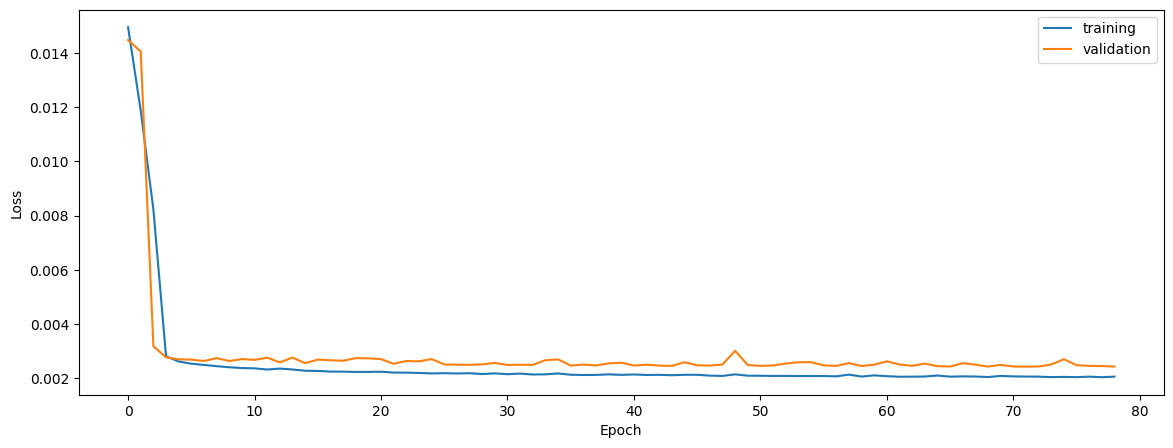

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


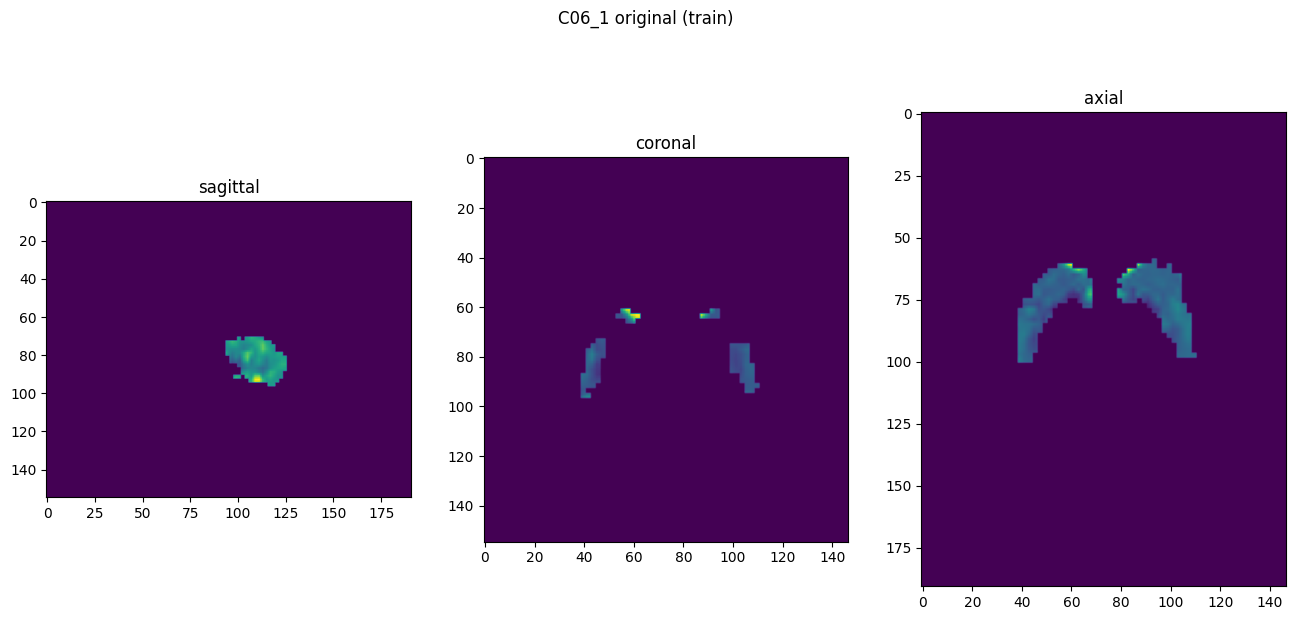

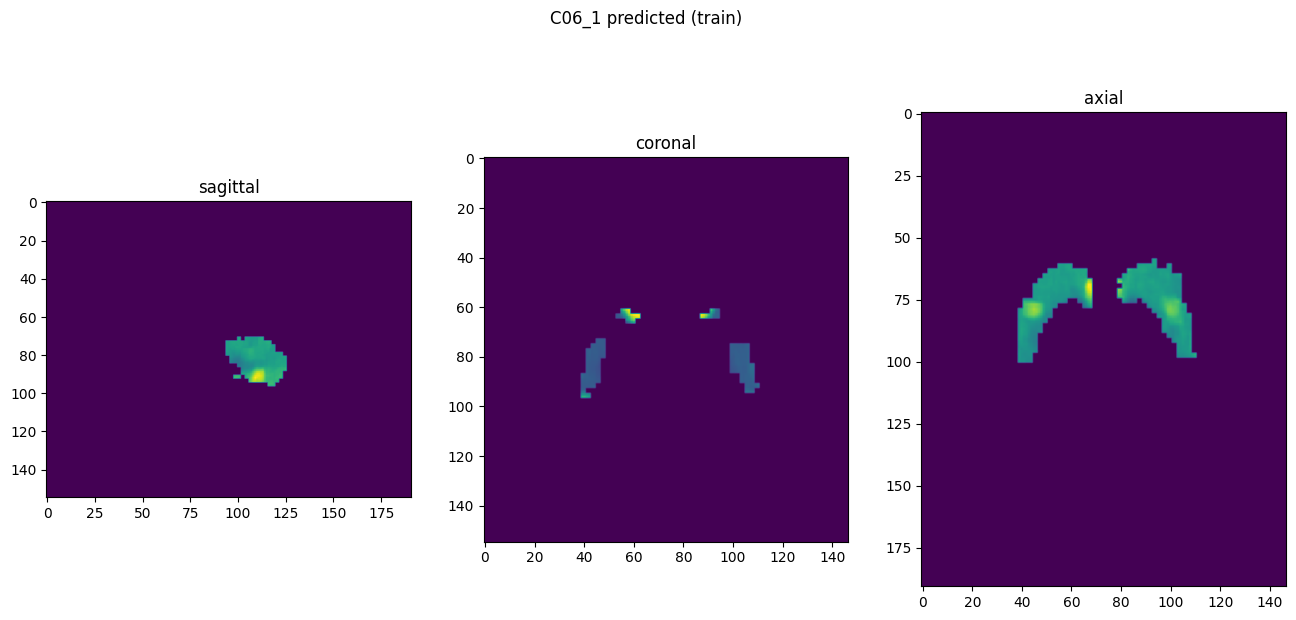

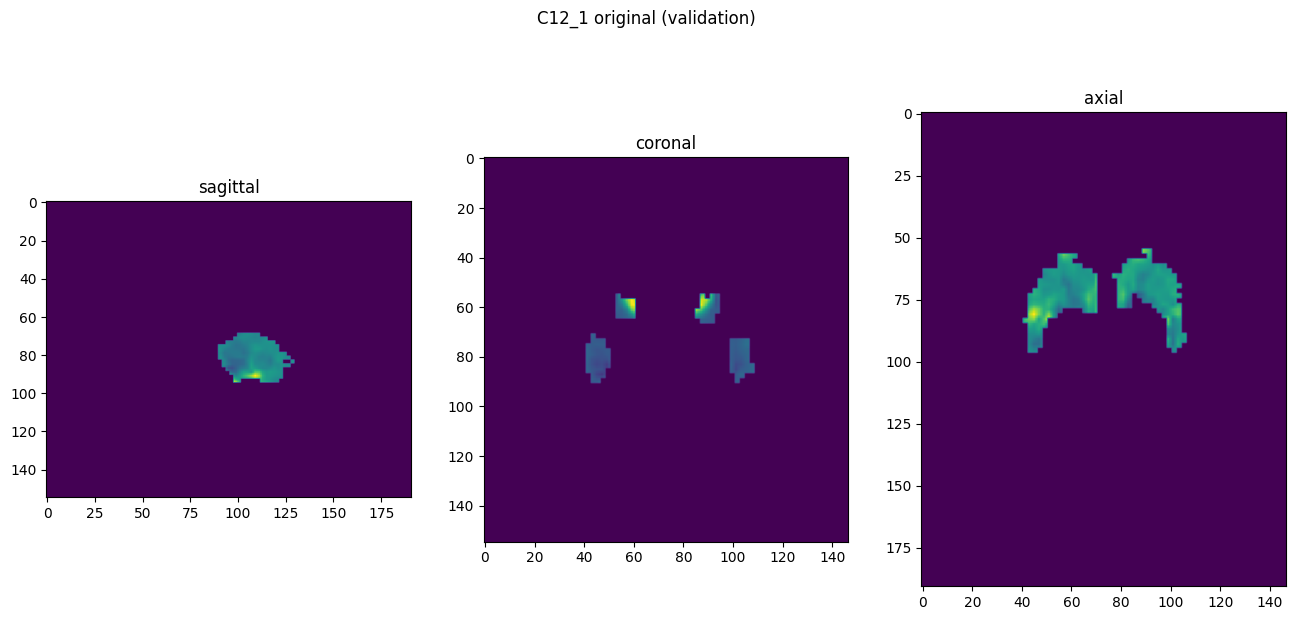

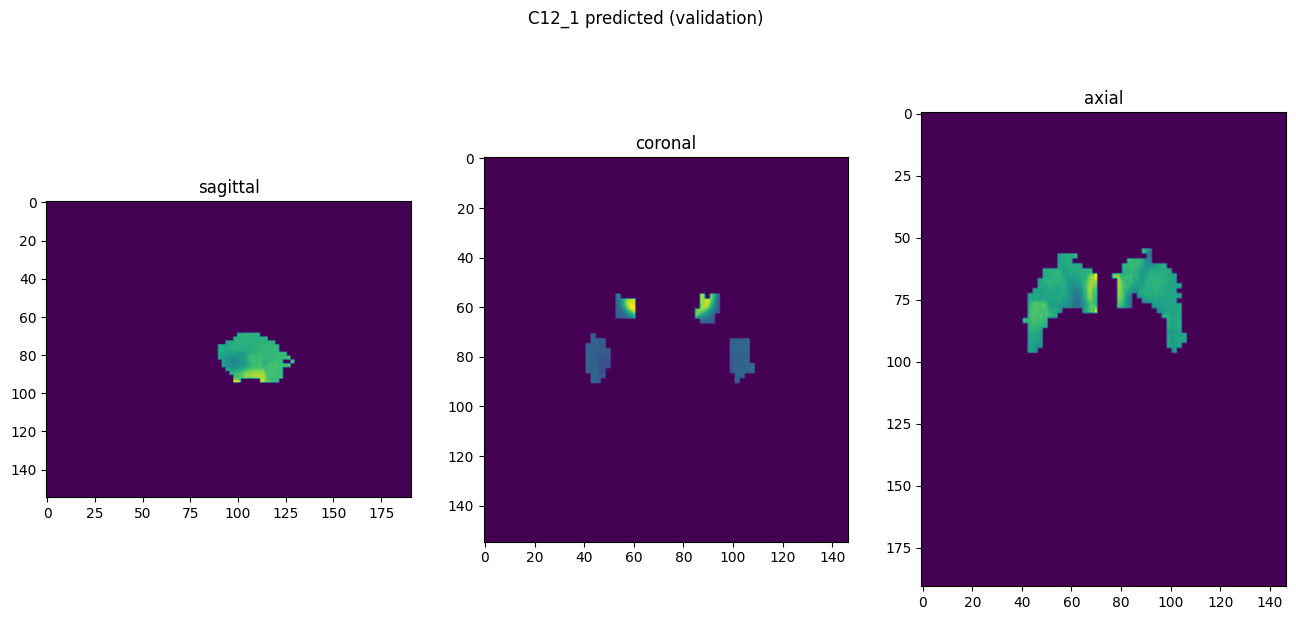

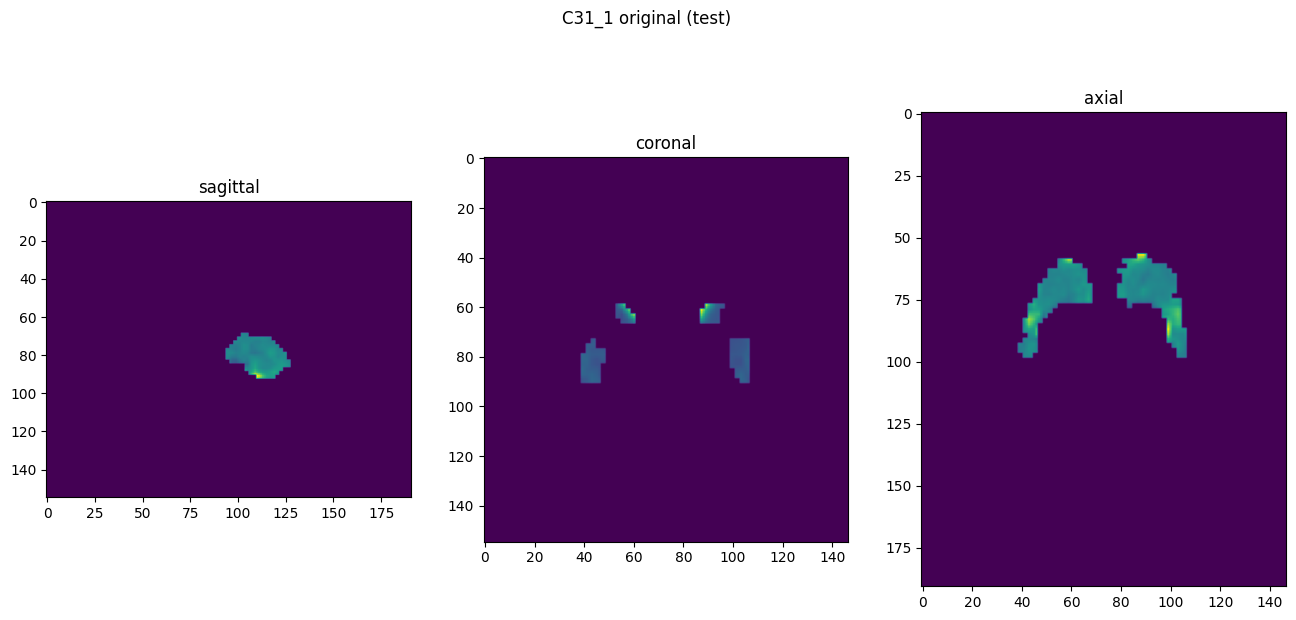

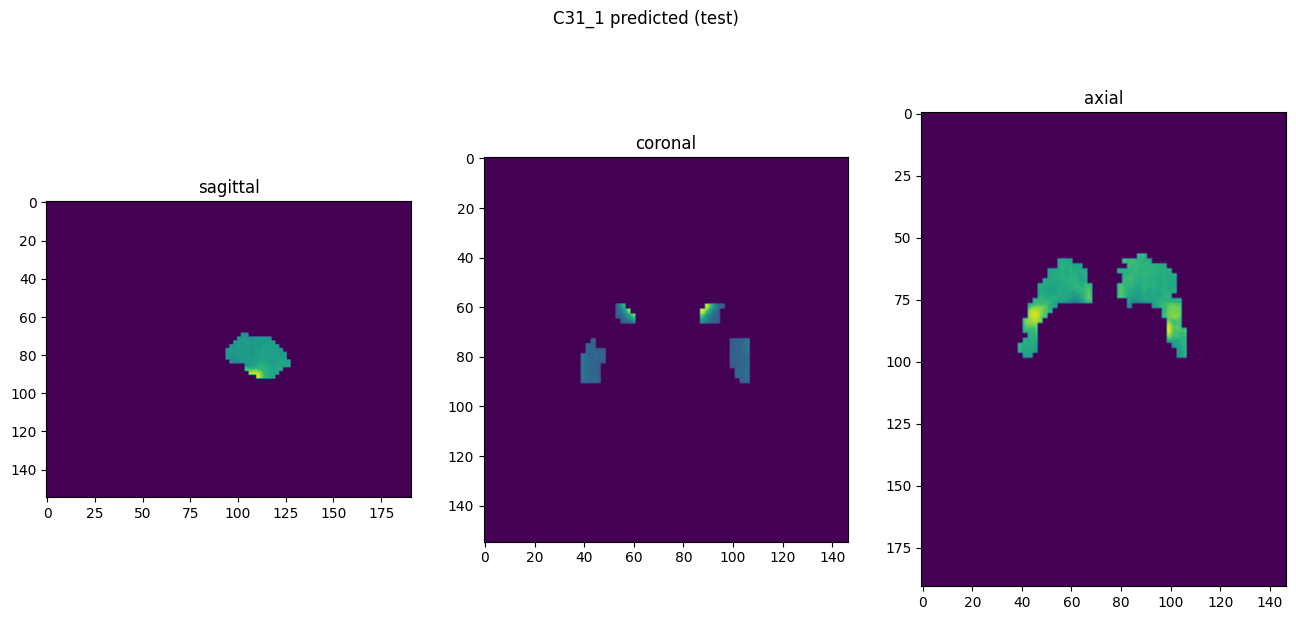

In [10]:
showResults(model, gen, threshold=None, background=False)